In [169]:
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from plotnine import *

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [170]:
db = pd.read_csv('data/train.csv')
test_db = pd.read_csv('data/val.csv')

db_wthno_na = db.copy()
test_db_wthno_na = test_db.copy()

db_wthno_na = db_wthno_na.replace('na', 0)
test_db_wthno_na = test_db_wthno_na.replace('na', 0)

col_size = db.shape[1]
for column in db:
    naCount = len(db[db[column] == 'na'])
    test_naCount = len(test_db[test_db[column] == 'na'])
    
    db_wthno_na[column] = pd.to_numeric(db_wthno_na[column])
    test_db_wthno_na[column] = pd.to_numeric(test_db_wthno_na[column])
    
    db_sum = db_wthno_na[column].sum()
    test_sum = test_db_wthno_na[column].sum()
    
    avg = db_sum/(col_size - naCount)
    test_avg = test_sum/(col_size - test_naCount)
    db[column] = db[column].replace('na', avg)
    test_db[column] = test_db[column].replace('na', test_avg)
        
print("Replace \'na\' values to avg of current column")

Replace 'na' values to avg of current column


In [171]:
db.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,78023,121.079395,-9.343143,25.46583,22.53827,21.52258,-109.962,-111.916,1,107.03430,...,-0.1840898,-0.05463289,0.0479114,0.398411,6,5,6,5,2,0
1,67239,121.080753,-9.339397,23.64559,24.57786,21.76326,20.94348,21.52855,1,134.68570,...,0.3717134,-0.1285481,-0.1223638,0.398411,6,8,1,1,0,0
2,48461,121.070386,-9.332728,24.88126,23.49473,22.23877,21.38574,21.51635,1,84.76380,...,0.004124804,0.01414719,-0.05156832,0.398411,6,4,6,4,5,0
3,55564,121.083052,-9.334026,23.57384,21.42411,20.43948,19.99905,19.82959,1,177.05670,...,-0.08095889,-0.313548,-0.08930081,0.398411,3,4,5,2,4,0
4,96180,121.063351,-9.325032,23.85167,20.25245,19.6067,19.18877,19.08231,1,65.37769,...,-0.03782843,-0.09712007,0.0479114,0.1064725,3,4,7,6,3,0


In [172]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
objid    30000 non-null int64
ra       30000 non-null float64
dec      30000 non-null float64
u_0      30000 non-null object
g_0      30000 non-null object
r_0      30000 non-null object
i_0      30000 non-null object
z_0      30000 non-null object
clean    30000 non-null int64
rowc     30000 non-null float64
colc     30000 non-null float64
rowv     30000 non-null object
colv     30000 non-null object
u_1      30000 non-null float64
g_1      30000 non-null float64
r_1      30000 non-null float64
i_1      30000 non-null float64
z_1      30000 non-null float64
u_2      30000 non-null float64
g_2      30000 non-null float64
r_2      30000 non-null float64
i_2      30000 non-null float64
z_2      30000 non-null float64
u_3      30000 non-null object
g_3      30000 non-null object
r_3      30000 non-null object
i_3      30000 non-null object
z_3      30000 non-null object
u_4      30

In [173]:
db.columns.values

array(['objid', 'ra', 'dec', 'u_0', 'g_0', 'r_0', 'i_0', 'z_0', 'clean',
       'rowc', 'colc', 'rowv', 'colv', 'u_1', 'g_1', 'r_1', 'i_1', 'z_1',
       'u_2', 'g_2', 'r_2', 'i_2', 'z_2', 'u_3', 'g_3', 'r_3', 'i_3',
       'z_3', 'u_4', 'g_4', 'r_4', 'i_4', 'z_4', 'u_5', 'g_5', 'r_5',
       'i_5', 'z_5', 'u_6', 'g_6', 'r_6', 'i_6', 'z_6', 'class'],
      dtype=object)

In [174]:
db = db.drop("objid", axis = 1)
db = db.drop(columns=['ra', 'dec','rowc','colc', 'rowv', 'colv'])
X_train = db.drop("class", axis = 1)
Y_train = db['class'].copy()

test_db = test_db.drop("objid", axis = 1)
test_db = test_db.drop(columns=['ra', 'dec','rowc','colc', 'rowv', 'colv'])
X_test = test_db.drop("class", axis = 1)
Y_test = test_db['class'].copy()

In [175]:
corr_matrix = db.corr()
corr_matrix['class'].sort_values(ascending = False)

class    1.000000
g_6      0.458494
clean    0.392292
u_6      0.300989
i_6      0.288207
r_6      0.155243
u_1     -0.036846
r_1     -0.036979
z_1     -0.037078
i_1     -0.037292
g_1     -0.037314
u_2     -0.061867
i_2     -0.062052
z_2     -0.062753
r_2     -0.062826
g_2     -0.063284
z_6     -0.281688
Name: class, dtype: float64

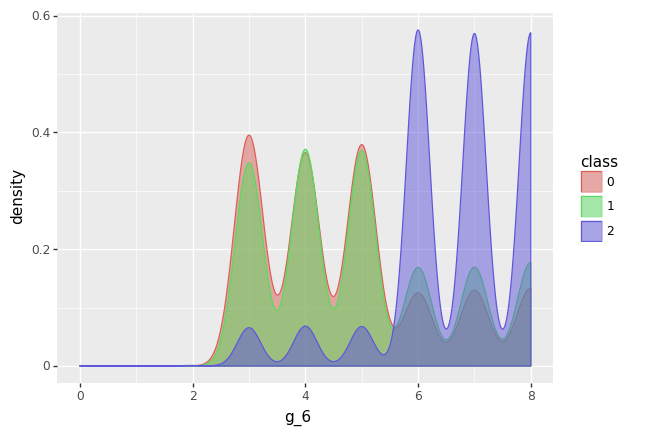

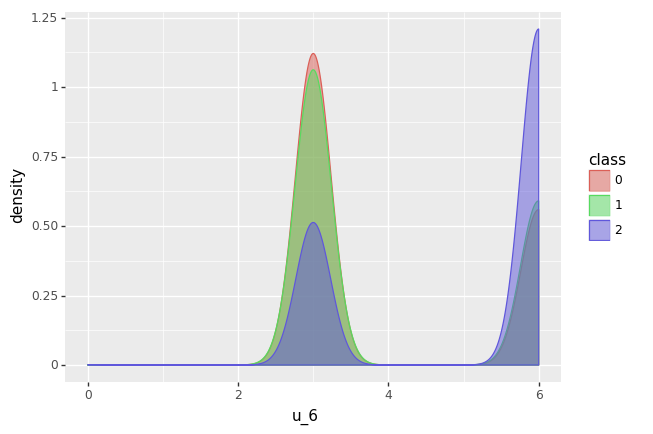

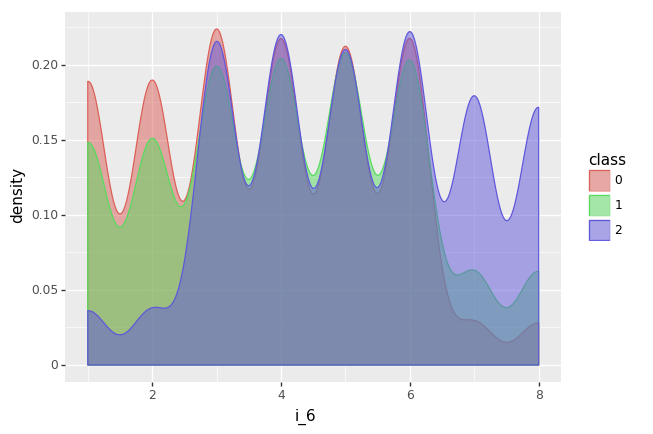

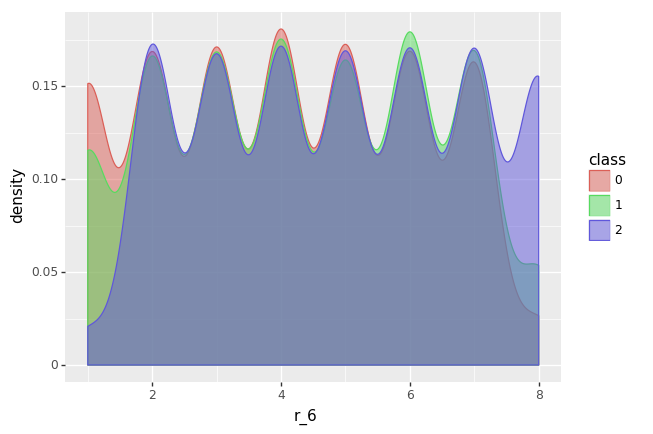

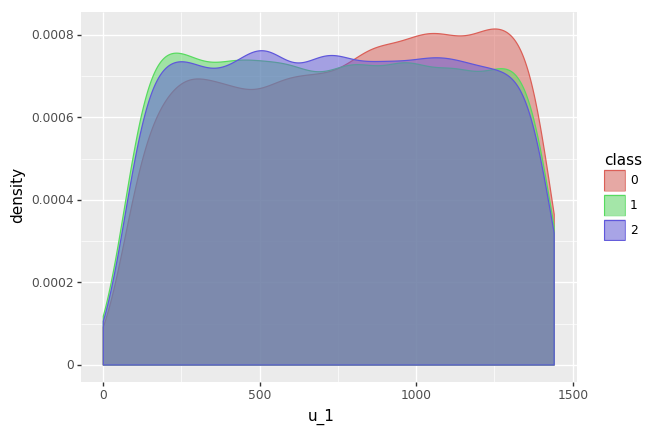

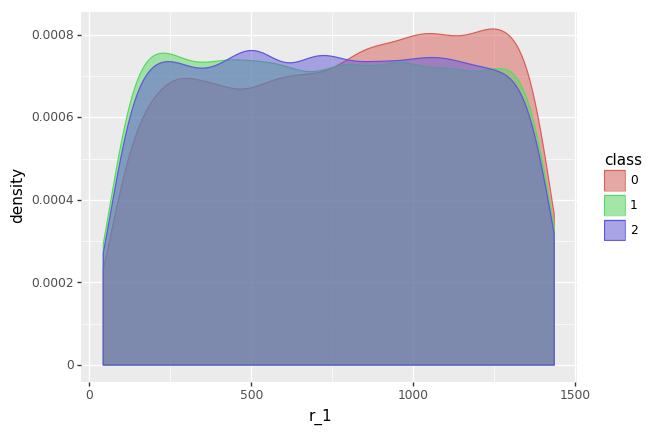

[<ggplot: (-9223363242171371425)>, <ggplot: (8794683162404)>, <ggplot: (-9223363242170178749)>, <ggplot: (-9223363242169921669)>, <ggplot: (8794684544232)>, <ggplot: (8794684544204)>]


In [182]:
db['class'] = db['class'].astype('category')

idx=0
max_idx=6
plots = []
class_corr_arr = corr_matrix['class'].sort_values(ascending = False).drop('clean')[1:]
for key, value in class_corr_arr.items():
    plots.append(ggplot(db, aes(x=key, color='class', fill='class')) + geom_density(alpha=0.5))
    idx += 1
    if idx == max_idx:
        break
print(plots)

In [164]:
default_forest = RandomForestClassifier(max_depth=15, n_estimators=50, max_features='auto',random_state=42)
default_forest.fit(X_train, Y_train)
default_forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [165]:
print("Test accuracy for default forest:", default_forest.score(X_test, Y_test))
print("F1 macro score:", f1_score(Y_test, default_forest.predict(X_test), average='macro'))

Test accuracy for default forest: 0.8628551836454806
F1 macro score: 0.8335023766158748


In [166]:
Y_pred = default_forest.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix_pd = pd.DataFrame(data = conf_matrix, 
                              index = [0,1,2],
                              columns = [0,1,2])
conf_matrix_pd

,0,1,2
0,12125,1008,200
1,610,3655,735
2,411,236,4353


In [167]:
feat_imp_pd = pd.DataFrame(data = default_forest.feature_importances_,
                          index = X_test.columns,
                          columns = ["Importance"])
feat_imp_pd = feat_imp_pd.sort_values(by = 'Importance', ascending = False)
feat_imp_pd

,Importance
g_6,0.126633
g_0,0.113122
z_0,0.089100
g_3,0.076821
i_0,0.072329
r_0,0.063604
i_3,0.057632
r_3,0.048019
u_3,0.043318
z_3,0.039460


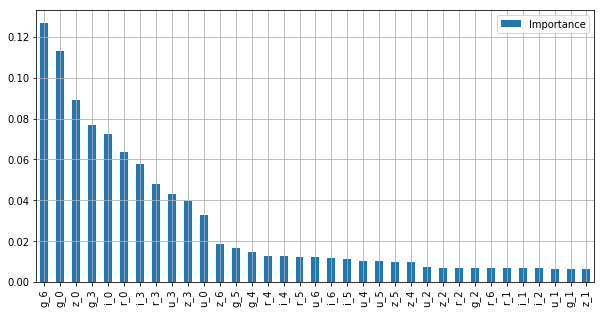

In [168]:
feat_imp_pd.plot(kind = "bar", figsize = (10,5), grid = True)
plt.show()